In [1]:
import pandas as pd
import helpsk.pandas as hp

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
df = pd.read_csv(
    url,
    names=[
        'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year',
        'Origin'
    ],
    na_values = "?", comment='\t', sep=" ", skipinitialspace=True
)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
df.dropna(inplace=True)

In [4]:
y_all = df['MPG'].values
y_all[0:10]

array([18., 15., 18., 16., 17., 15., 14., 14., 14., 15.])

In [5]:
X_all = df.drop(columns='MPG')
X_all.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,8,307.0,130.0,3504.0,12.0,70,1
1,8,350.0,165.0,3693.0,11.5,70,1
2,8,318.0,150.0,3436.0,11.0,70,1
3,8,304.0,150.0,3433.0,12.0,70,1
4,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=1)
assert len(X_train) + len(X_test) == len(X_all)
assert len(y_train) + len(y_test) == len(y_all)
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print(X_train.shape)
print(X_test.shape)

(313, 7)
(79, 7)


In [7]:
numeric_column_names = [
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
]
non_numeric_column_names = [
    'Cylinders',
    'Origin'
]

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import torch


numeric_pipeline = make_pipeline(StandardScaler())#.set_output(transform="pandas"))
non_numeric_pipeline = make_pipeline(OneHotEncoder())#.set_output(transform="pandas"))

def to_tensor(X):
    return torch.from_numpy(X).float()

pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_column_names),
        ('non_numeric', non_numeric_pipeline, non_numeric_column_names)
    ]),
    FunctionTransformer(func=to_tensor),
)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Displacement', 'Horsepower',
                                                   'Weight', 'Acceleration',
                                                   'Model Year']),
                                                 ('non_numeric',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Cylinders', 'Origin'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<function to_tensor at 0x7fcfb14f5f70>))])

In [9]:
Xt_train = pipeline.fit_transform(X_train)
Xt_test = pipeline.transform(X_test)

print(Xt_train.shape)
print(Xt_test.shape)

torch.Size([313, 13])
torch.Size([79, 13])


In [10]:
yt_train = torch.from_numpy(y_train).float()
yt_test = torch.from_numpy(y_test).float()

In [38]:
import torch
import torch.nn as nn
hidden_units = [8, 4]
input_size = Xt_train.shape[1]
print(f"Number of features: {input_size}")

all_layers = []
for hidden_unit in hidden_units:
    print(f"Creating Linear layer with {input_size} input units and {hidden_unit} hidden units.")
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

print(f"Creating output layer Linear layer with {input_size} input units and {hidden_units[-1]} output units.")
all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

# https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

model

Number of features: 13
Creating Linear layer with 13 input units and 8 hidden units.
Creating Linear layer with 8 input units and 4 hidden units.
Creating output layer Linear layer with 4 input units and 4 output units.
cpu


Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [39]:
# from torch.utils.data import DataLoader, TensorDataset

# n_train = len(Xt_train)
# train_tds = TensorDataset(Xt_train, y_train)
# batch_size = 9
# torch.manual_seed(1)
# train_dl = DataLoader(train_tds, batch_size, shuffle=True)

In [40]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
def train(X, y, model, num_epochs=200, batch_size=8, validation_size=0.1, random_seed=3):

    X_t, X_v, y_t, y_v = train_test_split(
        X, y, train_size=1-validation_size, random_state=random_seed
    )
    assert len(X_t) + len(X_v) == len(X)
    assert len(y_t) + len(y_v) == len(y)

    torch.manual_seed(1)

    loss_hist_train = np.empty(num_epochs)
    loss_hist_validation = np.empty(num_epochs)
    
    training_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        # batch_loss_training = np.empty(len(loader))
        # batch_loss_validation = np.empty(len(loader))
        # batch_records = np.empty(len(loader))

        model.train()
        for x_batch, y_batch in training_loader:            
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            pred = model(X_t)[:, 0]
            training_loss = loss_fn(pred, y_t)
            
            pred = model(X_v)[:, 0]
            validation_loss = loss_fn(pred, y_v)

            # training loss and validation loss
            loss_hist_train[epoch] = training_loss.item()
            loss_hist_validation[epoch] = validation_loss.item()

    return loss_hist_train, loss_hist_validation

history = train(X=Xt_train, y=yt_train, model=model)
history[0][0:20]

array([484.57495117,  14.95980453,  10.14408684,   9.0618372 ,
         8.66765976,  19.64285278,   9.55728054,   7.45935202,
         7.19782686,   6.92961311,   8.70359802,   6.98516464,
         6.97088337,   7.00607252,   9.40515232,   6.9307642 ,
         6.5215354 ,   8.57999897,   6.47597551,   7.67707062])

In [41]:
history[1][0:20]

array([404.4480896 ,  12.35930729,   8.39709091,   7.5459857 ,
         7.57278728,  19.55545425,   8.80958271,   7.24008465,
         6.84217644,   6.56228828,   7.6322093 ,   7.35250425,
         6.89065647,   7.0018115 ,   7.94019175,   6.46534061,
         6.49081707,   7.37385559,   6.24328136,   6.81849623])

In [42]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Text(0.5, 0, 'Epochs')

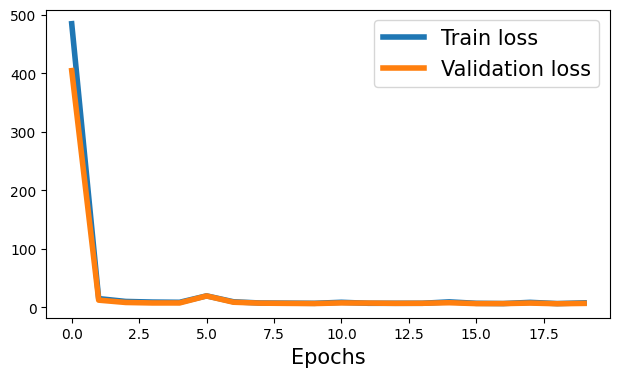

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0][0:20], lw=4)
plt.plot(history[1][0:20], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [44]:
# Context-manager that disabled gradient calculation.
# Disabling gradient calculation is useful for inference, when you are sure that you will not call
# Tensor.backward().
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.
with torch.no_grad():
    pred = model(Xt_test)[:, 0]
    loss = loss_fn(pred, yt_test)
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, yt_test).item():.4f}')

Test MSE: 9.8903
Test MAE: 2.0715


In [17]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

torch.manual_seed(1)
def train(X, y, model, num_epochs=200, batch_size=9, validation_size=0.8, random_seed=1):
    # n_train = len(X)
    # train_tds = TensorDataset(X, y)
    # batch_size = 9

    X_t, X_v, y_t, y_v = train_test_split(
        X, y, train_size=validation_size, random_state=random_seed
    )
    assert len(X_t) + len(X_v) == len(X)
    assert len(y_t) + len(y_v) == len(y)

    torch.manual_seed(1)

    loss_hist_train = np.empty(num_epochs)
    loss_hist_validation = np.empty(num_epochs)
    
    # def forward_backward(x_batch: torch.Tensor, y_batch: torch.Tensor) -> Tuple[float, int]:
    #     """
    #     Performs one step forward and back, returning the loss and size of the batch
    #     """
    #     pred = model(x_batch)[:, 0]
    #     loss = loss_fn(pred, y_batch)
    #     loss.backward()
    #     optimizer.step()
    #     optimizer.zero_grad()
    #     return loss.item(), len(x_batch)
    
    training_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        batch_loss_training = np.empty(len(training_loader))
        batch_loss_validation = np.empty(len(training_loader))
        batch_records = np.empty(len(training_loader))

        for i, (x_batch, y_batch) in enumerate(training_loader):
            batch_records[i] = len(x_batch)
            
            model.train()
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            batch_loss_training[i] = loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            model.eval()
            with torch.no_grad():
                pred = model(X_v)[:, 0]
                loss = loss_fn(pred, y_v)
                batch_loss_validation[i] = loss.item()
            
        loss_hist_train[epoch] = np.average(batch_loss_training, weights=batch_records)
        loss_hist_validation[epoch] = np.average(batch_loss_validation, weights=batch_records)
        
        # model.eval()
        # with torch.no_grad():
        #     pred = model(X_v)[:, 0]
        #     loss = loss_fn(pred, y_v)
        #     loss_hist_validation[epoch] = loss.item()
            # is_correct = ((pred>=0.5).float() == y_valid).float()
            # accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_validation

history = train(X=Xt_train, y=yt_train, model=model)
history[0][0:20]

array([4.95405658, 4.82492271, 4.54126108, 4.6460402 , 4.50748902,
       4.57670956, 4.60673112, 4.56256399, 4.53358512, 4.57615483,
       4.53116998, 4.41352494, 4.49303193, 4.53133405, 4.54574623,
       4.60035308, 4.55247551, 4.54054781, 4.34708993, 4.59252986])

In [18]:
history[1][0:20]

array([3.64495351, 3.65397399, 3.79595016, 3.6797734 , 3.70888356,
       3.7284716 , 3.83751507, 3.74026242, 3.91699602, 3.84000928,
       3.83532806, 3.97142472, 4.02338543, 3.94487882, 3.91259525,
       3.8839957 , 4.03776624, 3.97113646, 4.08186435, 4.19293188])

```
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20 
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        # The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss.
        # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Sets the gradients of all optimized torch.Tensor s to zero.
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        # In PyTorch, for every mini-batch during the training phase, we typically want to
        # explicitly set the gradients to zero before starting to do backpropragation
        # (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on
        # subsequent backward passes.
        loss_hist_train += loss.item()  # loss.item() gives average loss for this batch
    
    if epoch == 0 or epoch % log_epochs==0:
        num_batches = len(train_dl)
        n_train / batch_size
        print(f'Epoch {epoch}  Loss {loss_hist_train/(n_train / batch_size):.4f}')
```